## Linknet


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Read Data, Create train / valid splits

In [4]:
DATA_DIR = 'drive/MyDrive/deepglobe-land-cover-classification-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

### Helper functions for visualization & one-hot encoding/decoding

In [7]:
# Source: Gemini
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [18]:
class LandCoverDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

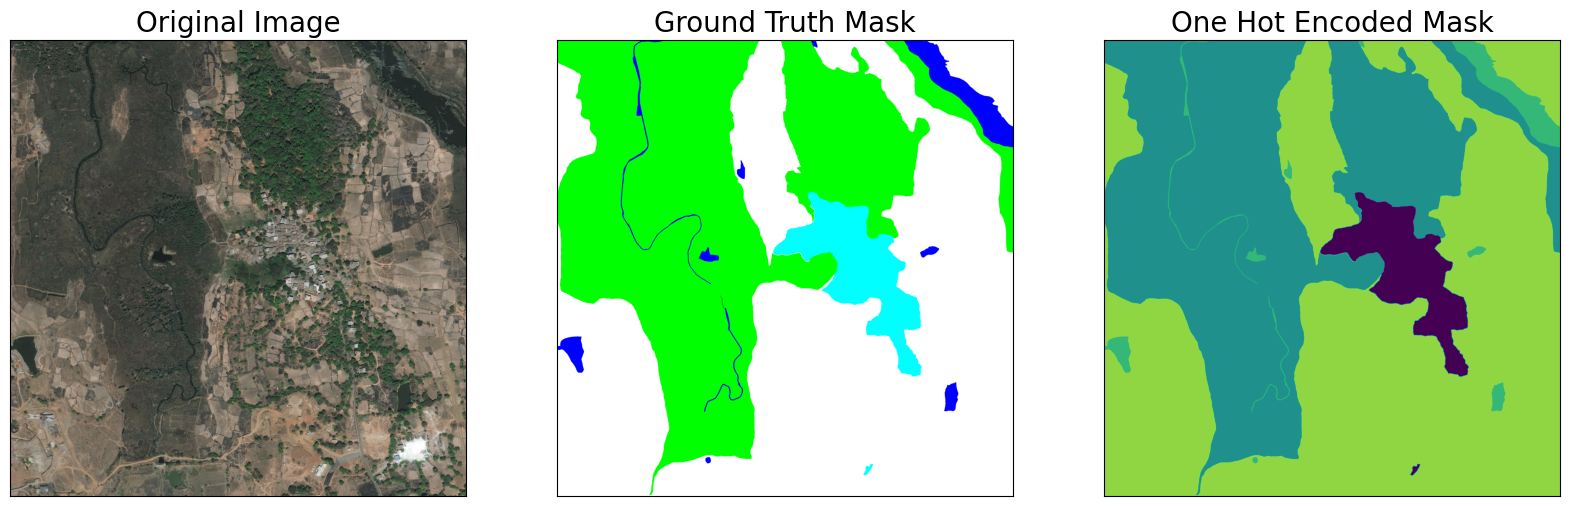

In [19]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

Augmentations

In [20]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True), # Added random crop instead of random brightness
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [21]:
augmented_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

## Training

### Model Definition

In [22]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model_name = 'Linknet'

# create segmentation model with pretrained encoder
model = smp.Linknet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [23]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

#### Set Hyperparams

In [24]:
from segmentation_models_pytorch import utils

TRAINING = True
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(f'./checkpoints/best_model_{model_name}.pth'):
    model = torch.load(f'./checkpoints/best_model_{model_name}.pth', map_location=DEVICE)
    print(f'Loaded pre-trained {model_name} model!')

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [26]:
%%time

if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, f'./best_model_{model_name}.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 80/80 [04:15<00:00,  3.19s/it, dice_loss - 0.6842, iou_score - 0.2581]
Model saved!

Epoch: 1
valid: 100%|██████████| 80/80 [02:25<00:00,  1.82s/it, dice_loss - 0.6374, iou_score - 0.3183]
Model saved!

Epoch: 2
valid: 100%|██████████| 80/80 [02:25<00:00,  1.82s/it, dice_loss - 0.6243, iou_score - 0.3841]
Model saved!

Epoch: 3
valid: 100%|██████████| 80/80 [02:26<00:00,  1.83s/it, dice_loss - 0.5611, iou_score - 0.4978]
Model saved!

Epoch: 4
valid: 100%|██████████| 80/80 [02:23<00:00,  1.80s/it, dice_loss - 0.529, iou_score - 0.5578]
Model saved!
CPU times: user 2h 8min 24s, sys: 8min 29s, total: 2h 16min 54s
Wall time: 2h 33min 26s


### Prediction on Test Data

In [27]:
if os.path.exists(f'./best_model_{model_name}.pth'):
    best_model = torch.load(f'./best_model_{model_name}.pth', map_location=DEVICE)
    print(f'Loaded {model_name} model from this run.')

elif os.path.exists(f'./checkpoints/best_model_{model_name}.pth'):
    best_model = torch.load(f'./checkpoints/best_model_{model_name}.pth', map_location=DEVICE)
    print(f'Loaded {model_name} model from a previous commit.')

Loaded Linknet model from this run.


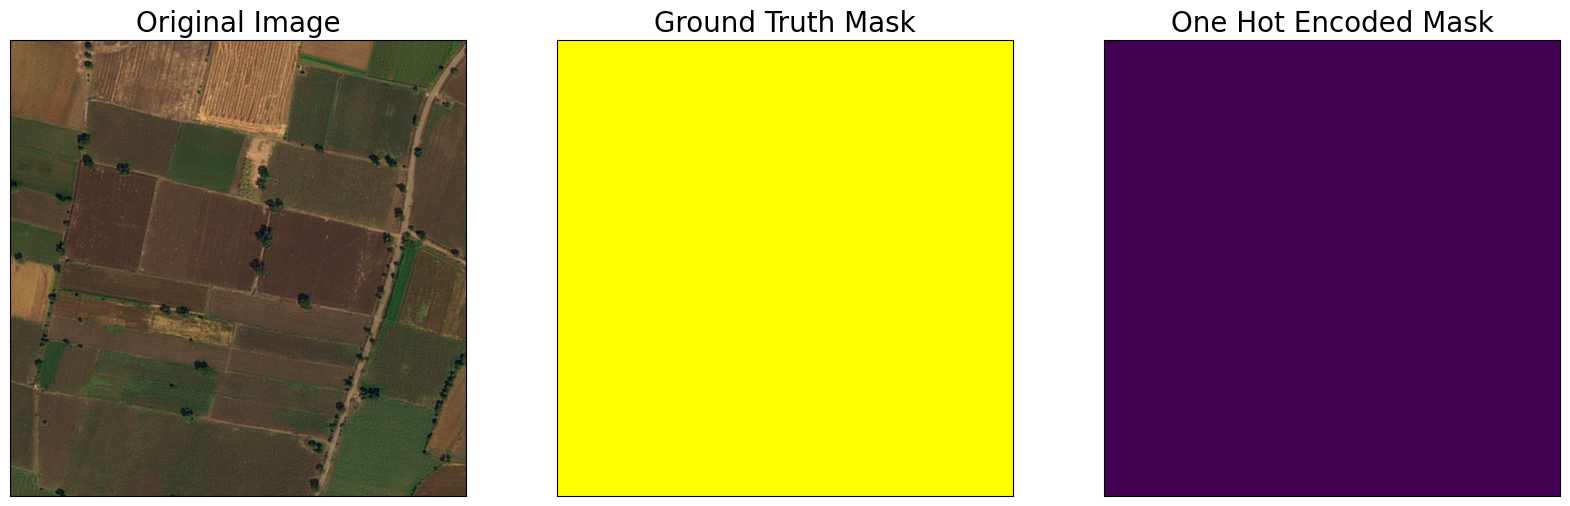

In [28]:
test_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [29]:
# Save predictions
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [30]:
best_model = model

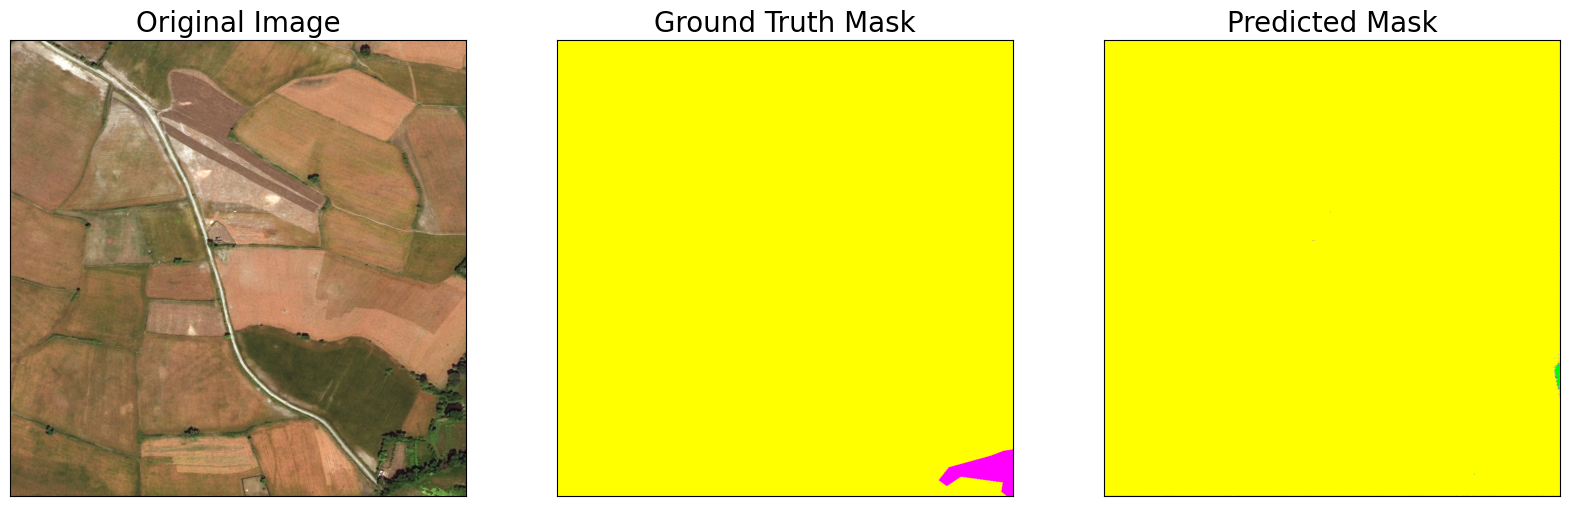

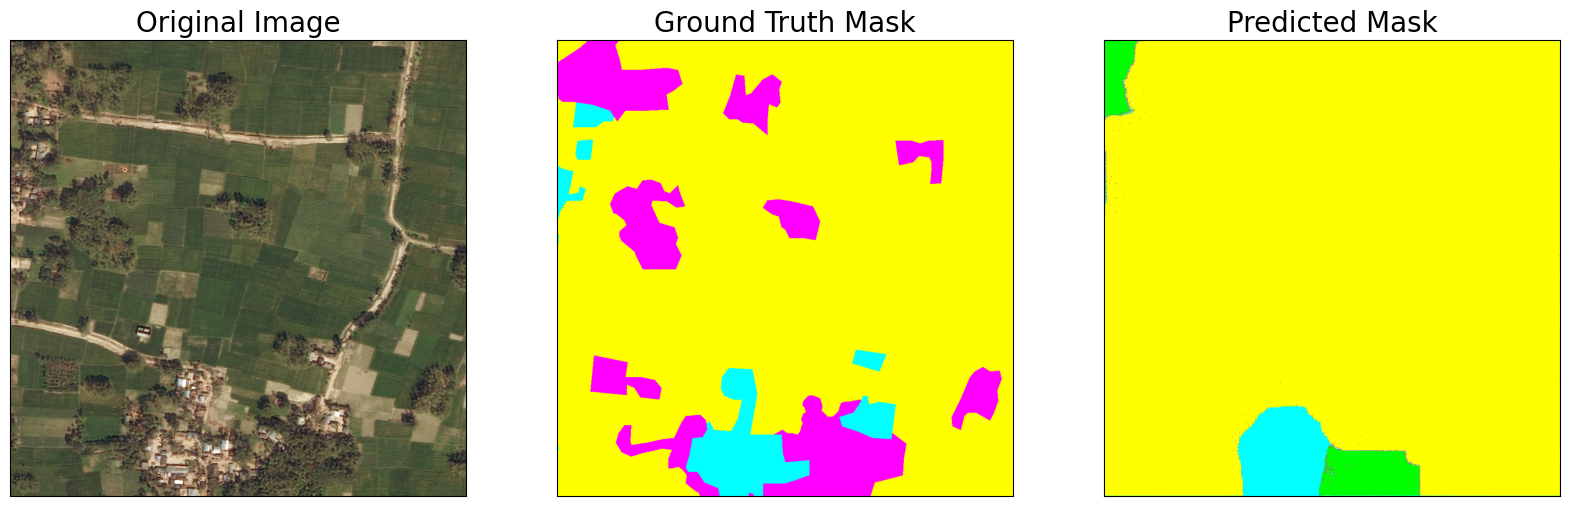

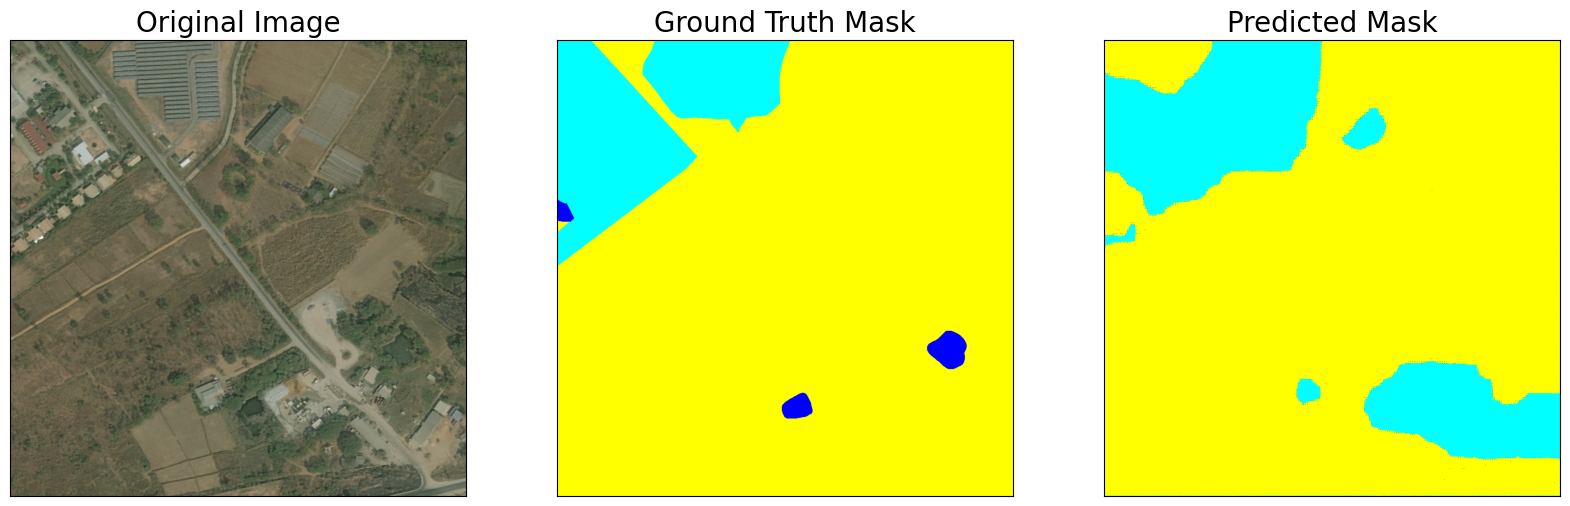

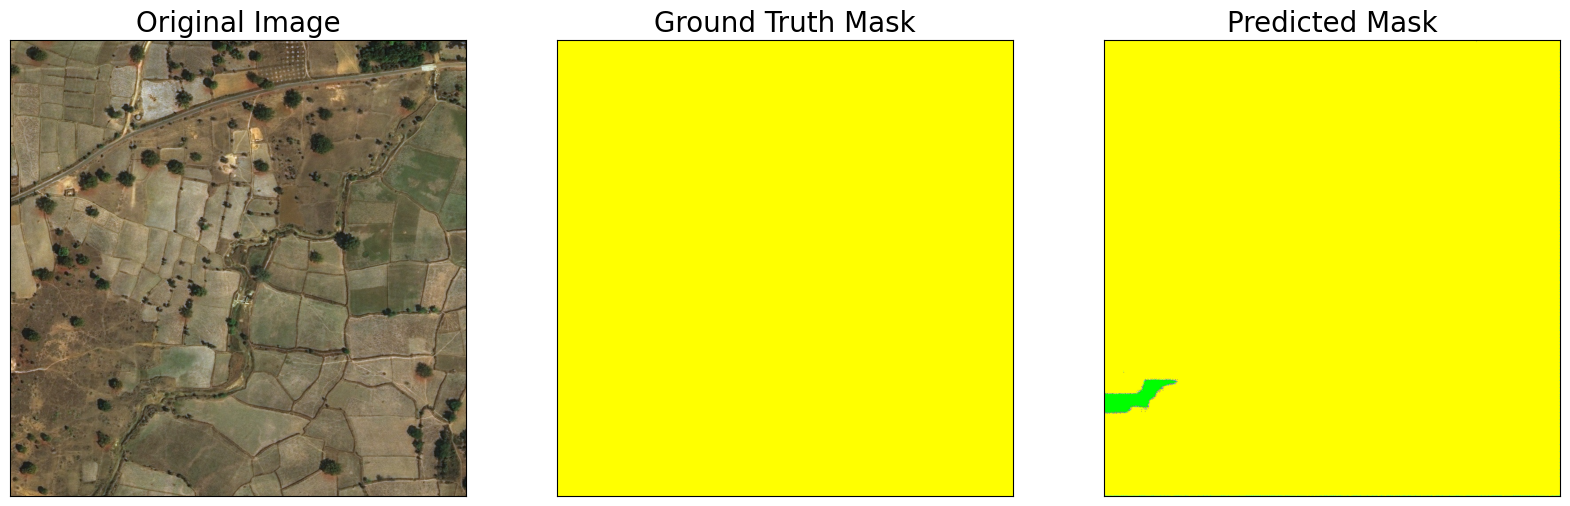

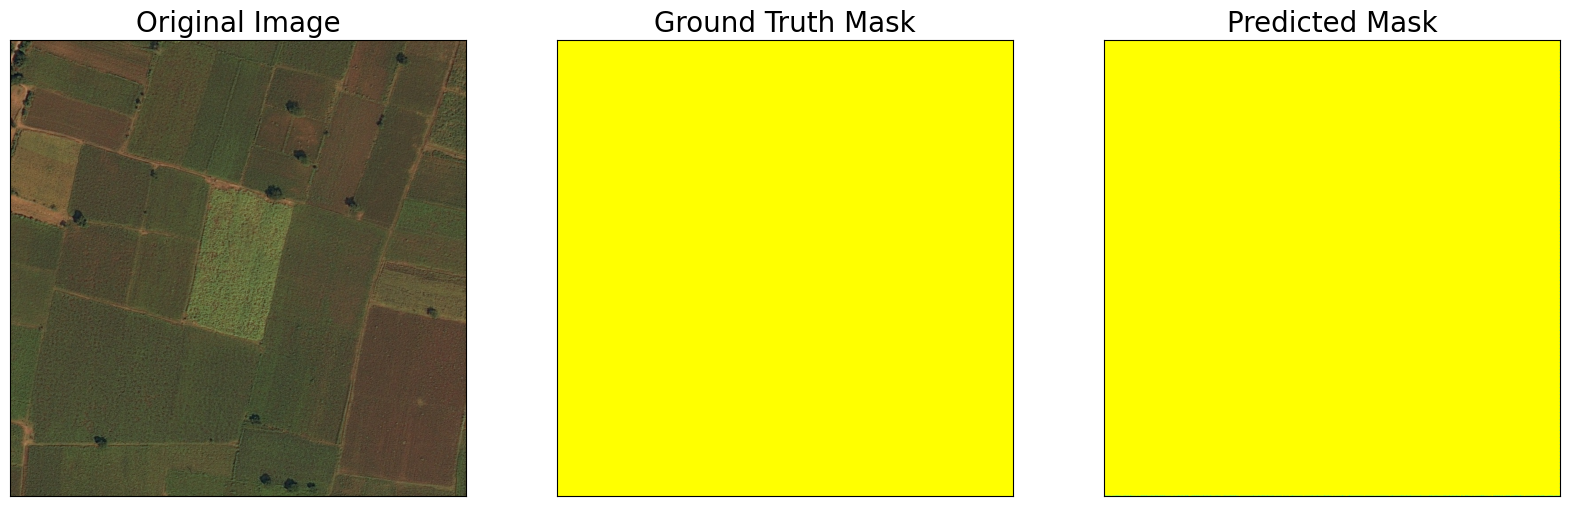

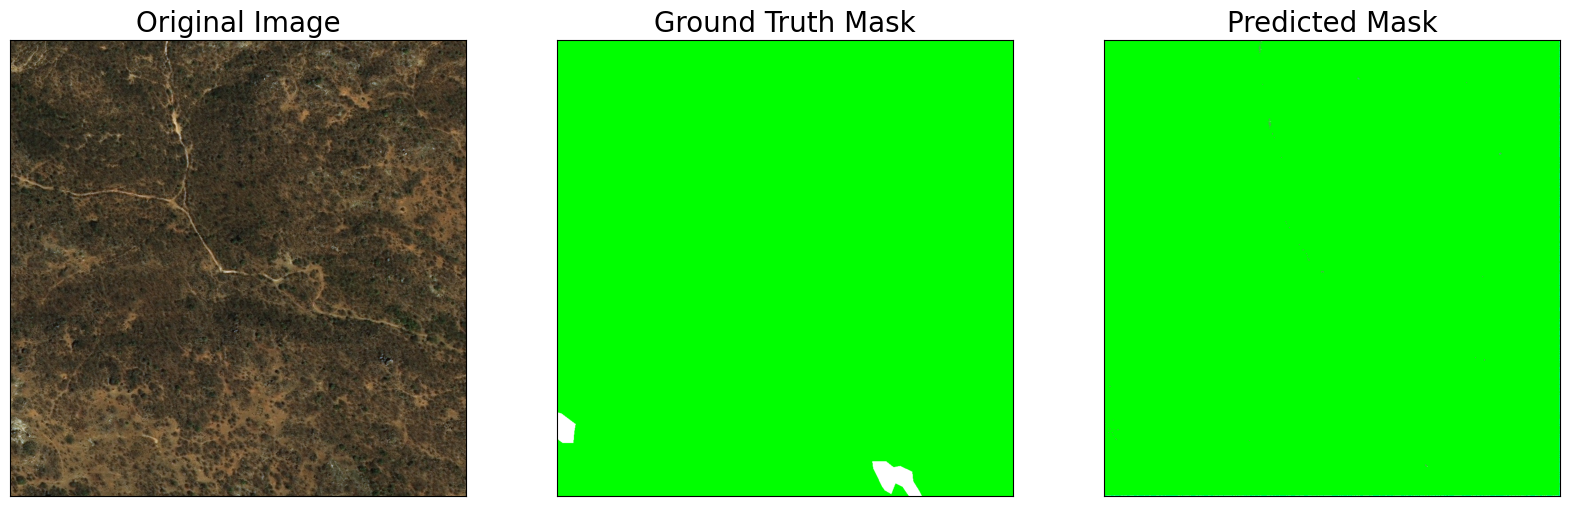

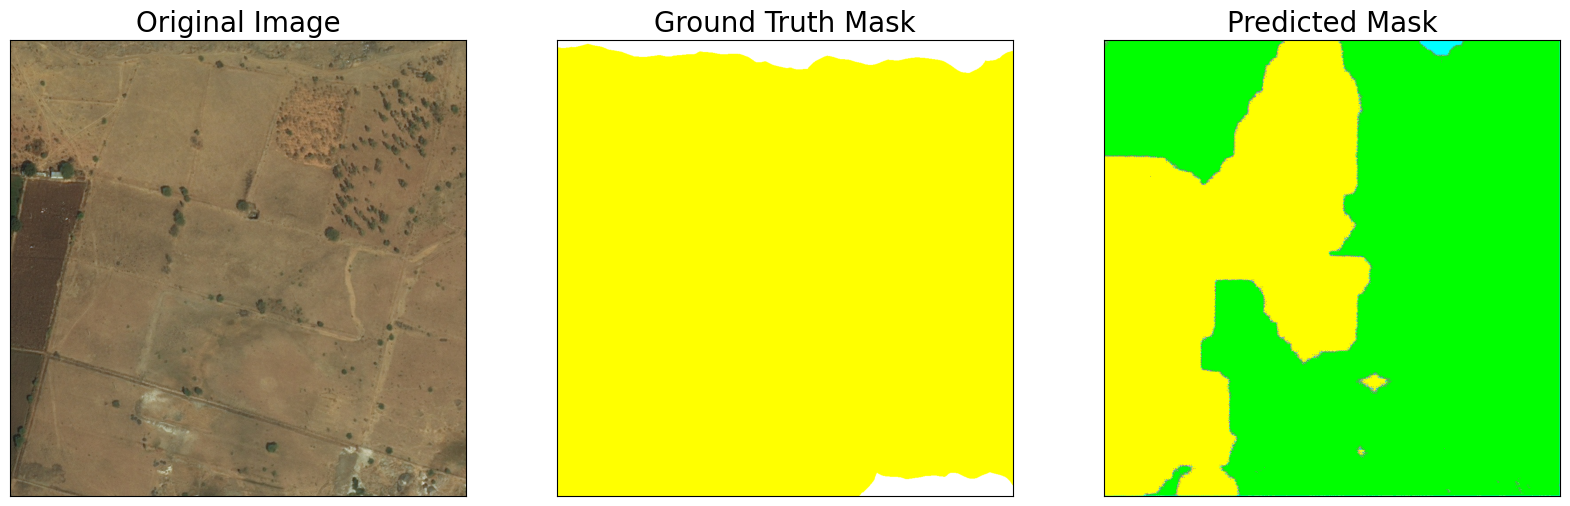

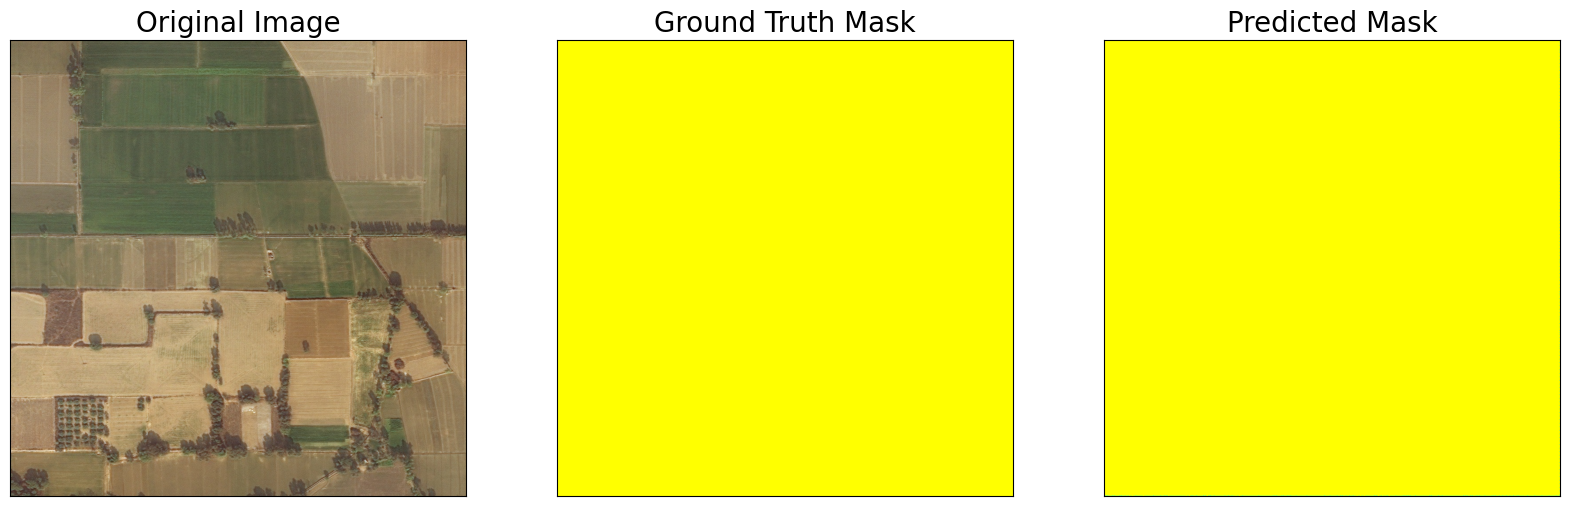

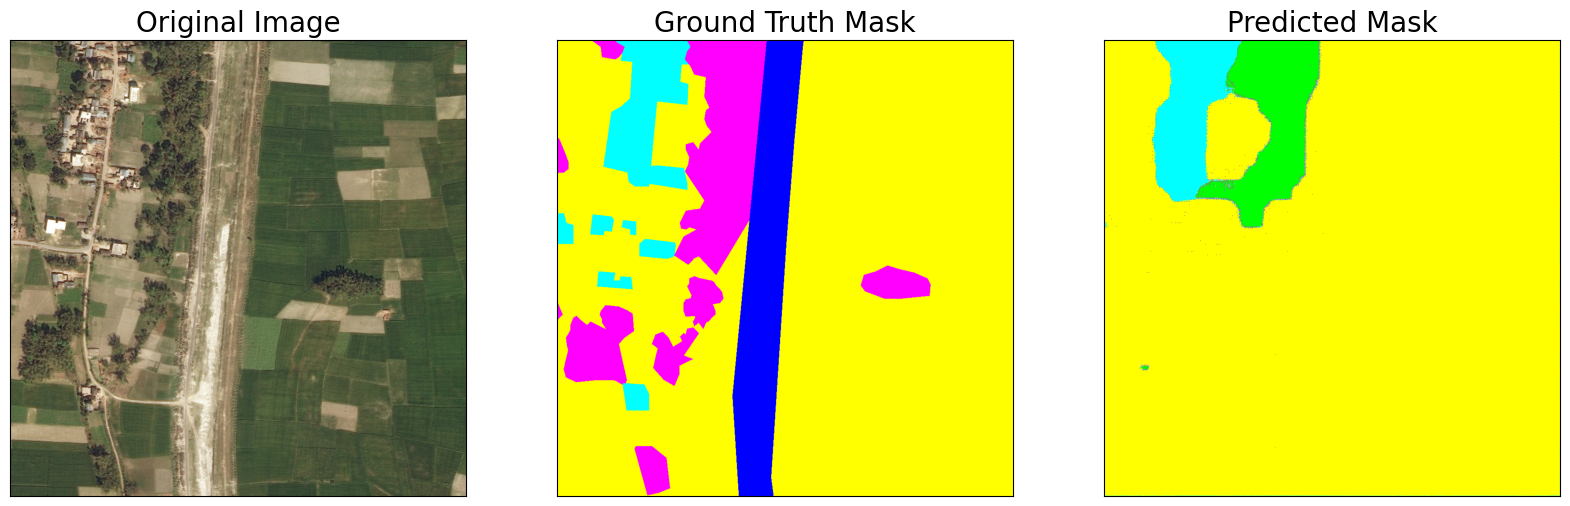

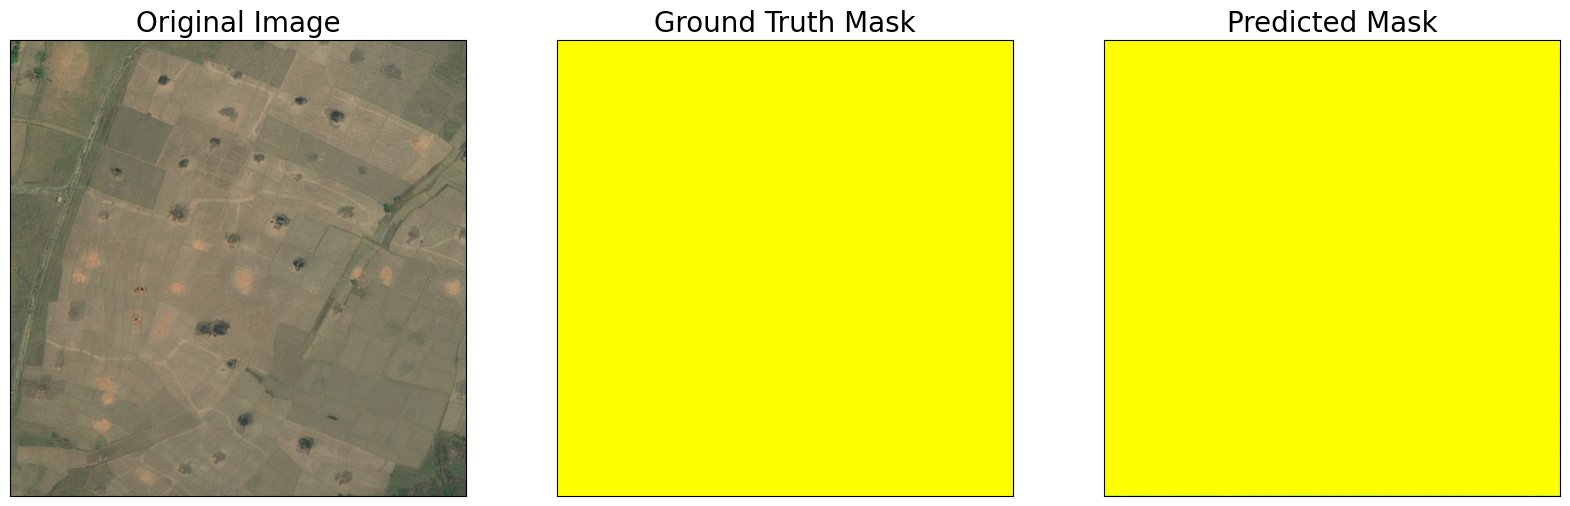

In [31]:
for idx in range(10):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
    )

### Model Evaluation on Test Dataset

In [32]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 80/80 [02:35<00:00,  1.95s/it, dice_loss - 0.529, iou_score - 0.5578]
Evaluation on Test Data: 
Mean IoU Score: 0.5578
Mean Loss: 0.5290


In [33]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4
dice_loss  0.731379  0.681411  0.651016  0.615283  0.586333
iou_score  0.196125  0.254811  0.310522  0.371248  0.418281

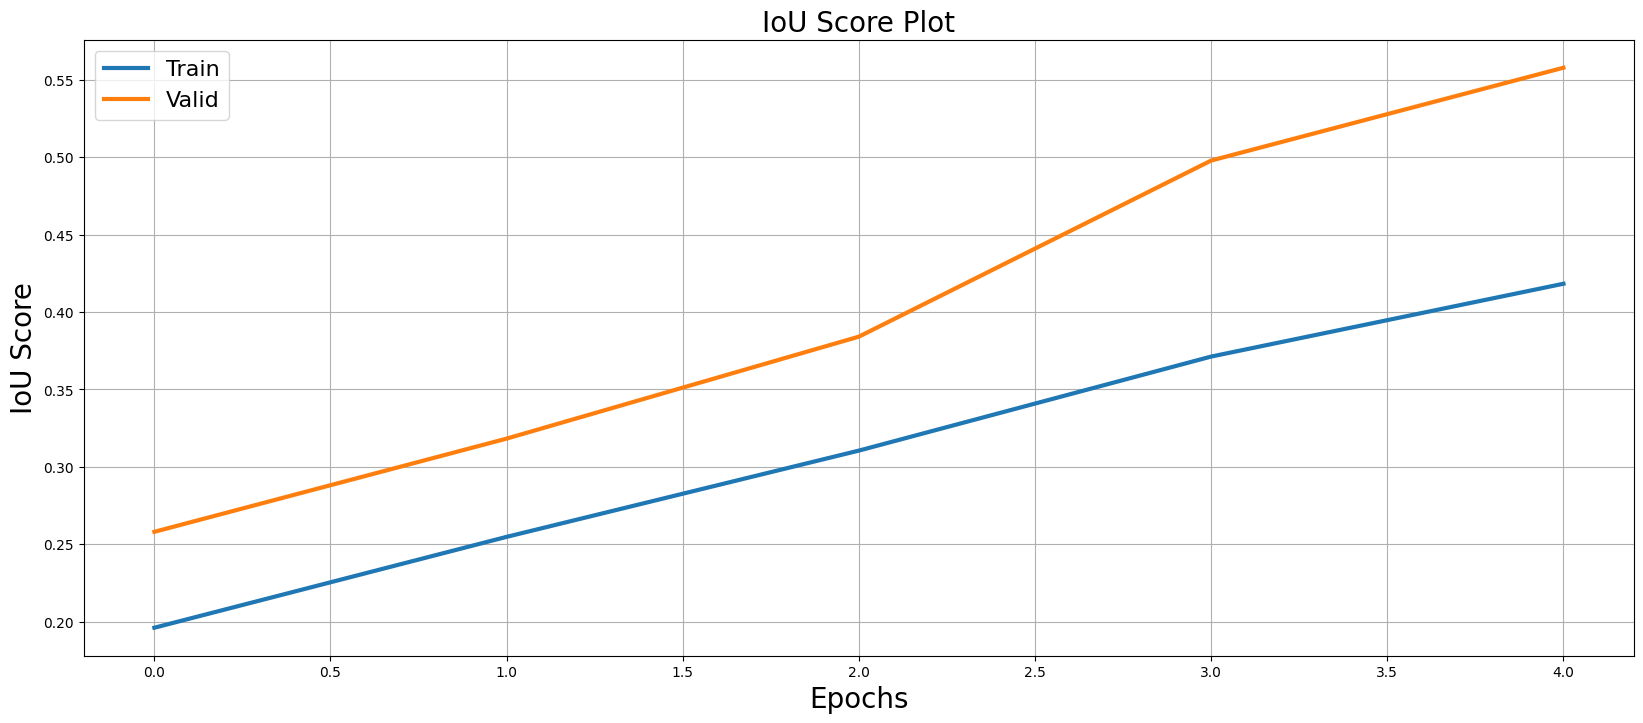

In [34]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'{model_name}_iou_score_plot.png')
plt.show()

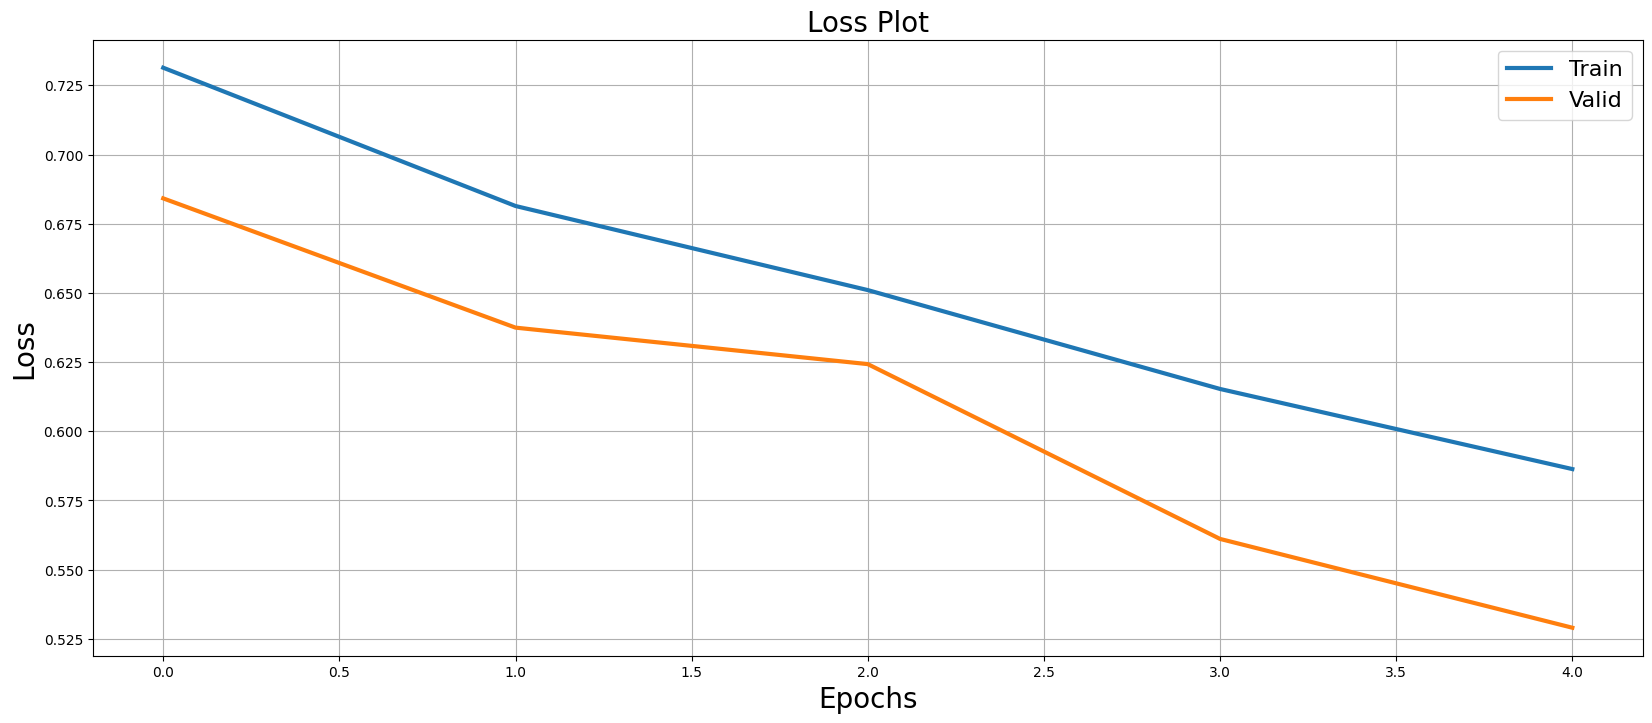

In [35]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'{model_name}loss_plot.png')
plt.show()